In [140]:
#importing needed libraries
import pandas as pd
import numpy as np

import requests
!pip install geopandas
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
!pip install geocoder

     |████████████████████████████████| 972kB 10.1MB/s eta 0:00:01
     |████████████████████████████████| 10.9MB 40.8MB/s eta 0:00:01
     |████████████████████████████████| 14.7MB 22.1MB/s eta 0:00:01
     |████████████████████████████████| 1.8MB 35.9MB/s eta 0:00:01


In [84]:
!pip install folium

In [95]:
import os
import geocoder
from geopy.geocoders import Nominatim

In [98]:
#new york coordinates finder function
def geo_locator(address):
    geolocator = Nominatim(user_agent = "ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude, longitude

In [99]:
#### function to find venues
def venue_locator(lat, long):
    #set variable
    radius = 1000
    limit = 150
    VERSION = '20200717'
    
    #URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id=JFM3UIEPG3PO0KRXV3C2DA2SMWWTXKNX2GM3HD1WXFOWTXIR&client_secret=AUMTELMIB4YZVXXFDQZCGDRDLOK23FQWS4VU0HFHCX0SES0P&v={}&ll={},{}&radius={}&limit={}'.format(
            VERSION, 
            lat, 
            long, 
            radius, 
            limit
    )
    
    #data
    results = requests.get(url).json()
    venue_data = results["response"]['groups'][0]['items']
    details =[]
    for row in venue_data:
        try:
            venue_id = row['venue']['id']
            venue_name = row['venue']['name']
            category = row['venue']['categories'][0]['name']
            details.append([venue_id,venue_name,category])
        except KeyError:
            pass
    
    column_names = ['ID', 'Name', 'Category']
    df = pd.DataFrame(details, columns = column_names)
    return df

In [54]:
# function to get details about venue

def venue_details(id):

    VERSION = '20200717'
    
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id=JFM3UIEPG3PO0KRXV3C2DA2SMWWTXKNX2GM3HD1WXFOWTXIR&client_secret=AUMTELMIB4YZVXXFDQZCGDRDLOK23FQWS4VU0HFHCX0SES0P&v={}'.format(
            id,
            VERSION)
    
    results = requests.get(url).json()
    data = results['response']['venue']
    details = []
    try:
        venueid = data['id']
        name = data['name']
        likes = data['likes']['count']
        rating = data['rating']
        tips = data['tips']['count']
        details.append([venueid, name, likes, rating, tips])
    except KeyError:
        pass
    
    df = pd.DataFrame(details, columns = ['ID', 'Name', 'Likes', 'Rating', 'Tips'])
    return df

In [36]:
# function for New York neighborhoods
def get_NewYork():
    
    resp = requests.get('https://cocl.us/new_york_dataset').json()
    feature = resp['features']
    
    # new data frame
    columnnames = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']
    newyorkdata = pd.DataFrame(columns = columnnames)
    
    for data in feature:
        borough = data['properties']['borough']
        neighborhoodname = data['properties']['name']
        
        neighborhoodcoord = data['geometry']['coordinates']
        neighborhoodlat = neighborhoodcoord[1]
        neighborhoodlong = neighborhoodcoord[0]
        
        newyorkdata = newyorkdata.append({'Borough': borough, 'Neighborhood': neighborhoodname, 'Latitude':neighborhoodlat, 'Longitude': neighborhoodlong}, ignore_index = True)
        
    return newyorkdata

In [37]:
newyorkdata = get_NewYork()
newyorkdata.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [42]:
#Getting Filipino restaurants in each neighborhood

columnnames = ['Borough', 'Neighborhood', 'ID', 'Name']
filipino_eat = pd.DataFrame(columns = columnnames)
i = 1
for row in newyorkdata.values.tolist():
    Borough, Neighborhood, Latitude, Longitude = row
    restaurants = venue_locator(Latitude,Longitude)
    filipinorest = restaurants[restaurants['Category'] == 'Filipino Restaurant']
    for rest_details in filipinorest.values.tolist():
        id, name, category = rest_details
        filipino_eat = filipino_eat.append({'Borough': Borough, 'Neighborhood': Neighborhood, 'ID': id, 'Name': name}, ignore_index = True)
    
    i = i+1

In [49]:
filipino_eat.shape
# 20 restaurants in range

(20, 4)

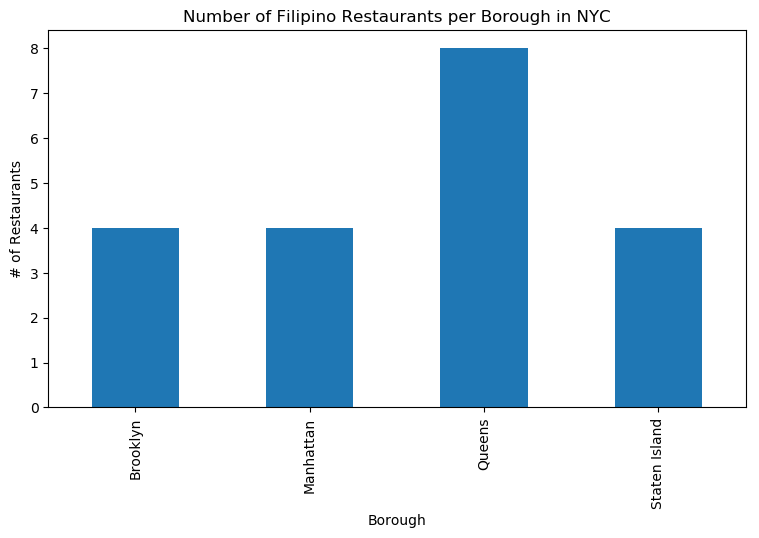

In [44]:
plt.figure(figsize = (9,5), dpi=100)
plt.title('Number of Filipino Restaurants per Borough in NYC')
plt.xlabel('Borough', fontsize = 10)
plt.ylabel('# of Restaurants', fontsize = 10)
filipino_eat.groupby('Borough')['ID'].count().plot(kind = 'bar')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

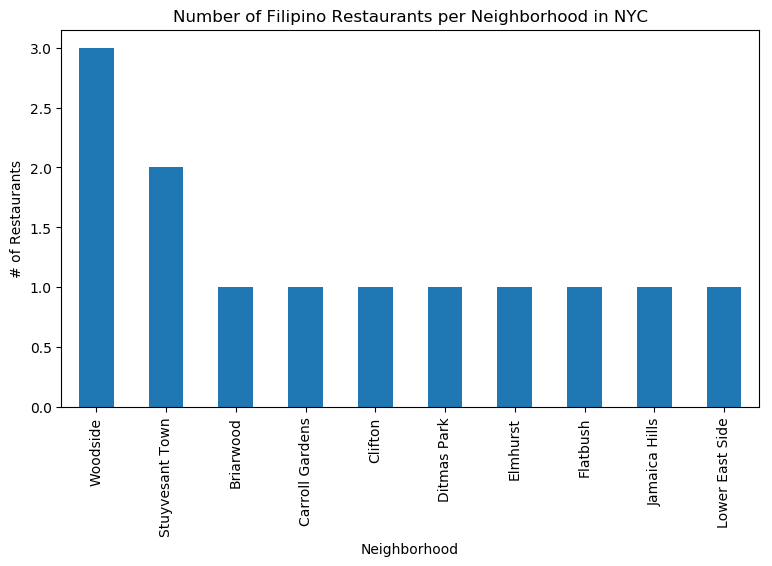

In [45]:
plt.figure(figsize = (9,5), dpi = 100)
plt.title('Number of Filipino Restaurants per Neighborhood in NYC')
plt.xlabel('Neighborhood', fontsize = 10)
plt.ylabel('# of Restaurants', fontsize = 10)
filipino_eat.groupby('Neighborhood')['ID'].count().nlargest(10).plot(kind = 'bar')
plt.show

In [46]:
columnsn = ['Borough', 'Neighborhood', 'ID', 'Name', 'Likes', 'Rating', 'Tips']
restaurantstats = pd.DataFrame(columns = columnsn)

In [50]:
column_names = ['Borough', 'Neighborhood', 'ID', 'Name', 'Likes', 'Rating', 'Tips']
rest_stats = pd.DataFrame(columns = column_names)

In [56]:
#gathering rating information
i = 1

for row in filipino_eat.values.tolist():
    Borough, Neighborhood, ID, Name = row
    try:
        rest_details = venue_details(ID)
        print(rest_details)
        id, name, likes, rating, tips = rest_details.values.tolist()[0]
    except IndexError:
        id, name, likes, rating, tips=[0]*5
    rest_stats = rest_stats.append({'Borough': Borough, 'Neighborhood': Neighborhood, 'ID': id, 'Name': name, 'Likes': likes, 'Rating': rating, 'Tips': tips}, ignore_index = True)
    
    i = i+1

                         ID        Name  Likes  Rating  Tips
0  4afa2432f964a520081722e3  Purple Yam    137     7.9    76
                         ID            Name  Likes  Rating  Tips
0  591e55677247502fb9514269  Fob Restaurant     55     7.8    28
                         ID        Name  Likes  Rating  Tips
0  4afa2432f964a520081722e3  Purple Yam    137     7.9    76
                         ID          Name  Likes  Rating  Tips
0  50588bc6526260483ab2860e  Pig and Khao   1081     9.0   301
                         ID             Name  Likes  Rating  Tips
0  53040a6e498ef035406f9cbf  House of Inasal     48     7.9    13
                         ID                          Name  Likes  Rating  Tips
0  4b5232def964a520456f27e3  Renee's Kitchenette & Grille     60     8.6    20
                         ID    Name  Likes  Rating  Tips
0  4a21ab5bf964a520277d1fe3  Ihawan     94     8.4    41
                         ID  Name  Likes  Rating  Tips
0  5ab83aff62420b3209673e48  Lahi     12 

In [58]:
rest_stats.to_csv('filipino_restaraunt_stats.csv', index = False)

In [60]:
statcsv = pd.read_csv('filipino_restaraunt_stats.csv')

In [63]:
statcsv['Likes'] = statcsv['Likes'].astype('float64')
statcsv['Tips'] = statcsv['Tips'].astype('float64')

In [65]:
neighborhoodstats = statcsv.groupby('Neighborhood', as_index = False).mean()[['Neighborhood', 'Rating']]
neighborhoodstats.columns = ['Neighborhood', 'Average Rating']

In [67]:
neighborhoodstats.sort_values(['Average Rating'], ascending = False)

,Neighborhood,Average Rating
8,Noho,9.0
7,Lower East Side,9.0
15,Sunnyside Gardens,9.0
14,Sunnyside,9.0
13,Stuyvesant Town,8.3
16,Woodside,8.3
5,Flatbush,7.9
10,Prospect Park South,7.9
3,Ditmas Park,7.9
1,Carroll Gardens,7.8


In [74]:
statcsv

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Flatbush,4afa2432f964a520081722e3,Purple Yam,137.0,7.9,76.0
1,Brooklyn,Carroll Gardens,591e55677247502fb9514269,Fob Restaurant,55.0,7.8,28.0
2,Brooklyn,Prospect Park South,4afa2432f964a520081722e3,Purple Yam,137.0,7.9,76.0
3,Manhattan,Lower East Side,50588bc6526260483ab2860e,Pig and Khao,1081.0,9.0,301.0
4,Queens,Woodside,53040a6e498ef035406f9cbf,House of Inasal,48.0,7.9,13.0
5,Queens,Woodside,4b5232def964a520456f27e3,Renee's Kitchenette & Grille,60.0,8.6,20.0
6,Queens,Woodside,4a21ab5bf964a520277d1fe3,Ihawan,94.0,8.4,41.0
7,Queens,Elmhurst,5ab83aff62420b3209673e48,Lahi,12.0,7.8,3.0
8,Queens,Sunnyside,4aecab47f964a52026ca21e3,Tito Rad's Grill & Restaurant,182.0,9.0,74.0
9,Queens,Briarwood,4c22a0bc9085d13a53af86cc,Asian Food Ltd.,13.0,6.3,6.0


In [77]:
newdf = pd.merge(neighborhoodstats, newyorkdata, on = 'Neighborhood')
newdf = newdf[['Neighborhood', 'Latitude', 'Longitude', 'Average Rating']]
newdf

,Neighborhood,Latitude,Longitude,Average Rating
0,Briarwood,40.710935,-73.811748,6.3
1,Carroll Gardens,40.680540,-73.994654,7.8
2,Clifton,40.619178,-74.072642,7.5
3,Ditmas Park,40.643675,-73.961013,7.9
4,Elmhurst,40.744049,-73.881656,7.8
5,Flatbush,40.636326,-73.958401,7.9
6,Jamaica Hills,40.711460,-73.796465,6.3
7,Lower East Side,40.717807,-73.980890,9.0
8,Noho,40.723259,-73.988434,9.0
9,Park Hill,40.609190,-74.080157,7.5


In [100]:
import folium
map = folium.Map(location = geo_locator('New York'), zoom_start = 12)

In [104]:
featgroup = folium.map.FeatureGroup()

for lat, long in newdf[['Latitude', 'Longitude']].values:
    featgroup.add_child(
        folium.CircleMarker([lat, long], radius = 12, color = 'orange', fill = True, fill_color = 'blue', fill_opacity = 0.6))
        

In [106]:
newdf['Label']=newdf['Neighborhood']+', '+newdf['Neighborhood']+'('+newdf['Average Rating'].map(str)+')'

In [108]:
for lat, long, label in newdf[['Latitude', 'Longitude', 'Label']].values:
    folium.Marker([lat, long], popup = label).add_to(map)
map.add_child(featgroup)